# Classification for the Spotify dataset
In the following, we will perform classification for the given dataset. Goal is _create a model classificator for labelling tracks by `genre`_.  
We will perform 3 attempts for this classification:
- multiclass classification with n_class = n_genra;
- multiclass classification with n_class < n_genra, and in particular we want to regroup consider some sort of 'basic' genra criterion. It has been considered the following classification: https://en.wikipedia.org/wiki/List_of_music_genres_and_styles;
- binary classification, not musical tracks vs musical tracks. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
from sklearn.model_selection import cross_val_score

## Evaluation metrics
Importing the metrics for evaluating performances.  
Here reporting some formulas in order to recap everything:  
$$Acc = \frac{TP + TN}{TP + TN + FP + FN} $$  
The F1 score can be interpreted as a harmonic mean (harmonic mean is the reciprocal of the aritmetic mean of the reciprocals. It is sometimes appropriate for situations when the average rate is desired) of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is F1 = 2 * (precision * recall) / (precision + recall):

$$F1_{\text{score}} = \frac{2TP}{2TP + FN + FP} $$  
$$Recall = \frac{TP}{TP + FN} $$

In [5]:
#Importing the performance metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [6]:
# importing datasets - one will be used for training, one for testing.
df_original_copy_training = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

In [7]:
df_train[(df_train['tempo'] < 20) | (df_train['time_signature'] <= 1)]

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
57,Blow the Man Down,117906,False,42,Mickey Mouse;The Gooey Fish,Mickey Mouse Clubhouse,0.725,0.552000,2,-9.030,...,0.101,0.9750,97.624,117907,1.0,186.0,46.0,NaN,3.700483,disney
129,Baadaabaad,290000,False,0,Rojin Sharafi,Zangaar,0.400,0.415000,7,-13.288,...,0.111,0.0383,88.553,290000,1.0,423.0,107.0,0.146,4.067086,iranian
267,Hair Dryer Sound 20 - Loopable With No Fade,84000,False,37,Deep Sleep Hair Dryers;Hair Dryer Collection;H...,Hair Dryers,0.000,0.000030,3,-22.367,...,0.443,0.0000,0.000,84000,0.0,0.0,0.0,NaN,1.738916,sleep
399,The World of the LSD-User,238608,False,25,Juggernaut,The World of the LSD-User,0.427,0.910000,6,-9.822,...,0.126,0.3790,164.840,238608,1.0,647.0,164.0,NaN,1.170953,happy
664,Brown Noise with Binaural Beats - Theta - Loop...,73886,False,34,Sleep Baby Sleep;White Noise Meditation;Delta ...,"Brown Noise, White Noise, and Binaural Beats E...",0.000,0.475000,9,-21.019,...,0.315,0.0000,0.000,73887,0.0,0.0,0.0,NaN,1.343558,sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,Hairdryer Sound for Sleep,168250,False,54,Pink Noise;Sleepy Times,Soothing Hum: Pink Noise,0.155,0.528000,1,-20.523,...,0.112,0.0236,82.845,168250,1.0,229.0,56.0,0.598,2.367412,sleep
14142,Clean White Noise - Loopable Without Fade,67682,False,39,White Noise Babies,Loopable White Noise For Baby Sleep,0.000,0.000020,10,-43.046,...,0.101,0.0000,0.000,67682,0.0,0.0,0.0,NaN,0.757389,sleep
14144,Soothing White Noise - Loopable With No Fade,65248,False,34,White Noise Sleep Sounds,Soothing White Noise,0.000,0.000687,10,-49.531,...,0.101,0.0000,0.000,65248,0.0,0.0,0.0,NaN,0.757389,sleep
14185,Matkar Maya Ko Ahankar,365672,False,54,Kabir Cafe,Panchrang,0.796,0.517000,1,-6.289,...,0.138,0.6140,107.475,365673,1.0,649.0,162.0,NaN,2.367412,indian


# Data preparation: transformation and preprocessing
This has to be done on both training set and test set. 

### Data transformation

In [8]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [9]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0
        
#Dealing with mode attribute missing values - test
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
list_of_nan_indexes_test=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_test:
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [10]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]
    
#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [11]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [12]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [13]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

In [14]:
df_test['genre'].value_counts()

genre
industrial       250
breakbeat        250
happy            250
afrobeat         250
study            250
black-metal      250
sleep            250
bluegrass        250
techno           250
brazil           250
j-dance          250
chicago-house    250
disney           250
iranian          250
mandopop         250
idm              250
spanish          250
j-idol           250
indian           250
forro            250
Name: count, dtype: int64

Pay attention, in train and test sets, genra does not have same order, it is necessary to use a dictionary map for BOTH. 

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [15]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [16]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats'] 
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -------------------------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` , `industrial`|
| 1 | Pop + Asian| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`, `indian`|
| 2 | Latin | `forro`,`brazil`,`spanish`|
| 3 | Country | `bluegrass`|
| 4 | Metal | `black metal`|
| 5 | Iranian | `iranian`|
| 6 | Others | `sleep`, `study`|

In [17]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":1,"iranian":5,"brazil":2,"chicago-house":0,"forro":2,"idm":0,"indian":1,"study":6,"disney":1,"afrobeat":0,"mandopop":1,"techno":0,"sleep":6,"spanish":2,"j-idol":1,"industrial":0,"happy":1,"bluegrass":3,"black-metal":4,"breakbeat":0}

#aa

NB: here _partitioning_ is not necessary because both train and test sets are already equally partitioned (so,holdout is not performed).

## First `genre` map - all genra in a different category

In [234]:
df_train.replace({'genre':genre_map}, inplace=True)
df_test.replace({'genre':genre_map}, inplace=True)

### Encoding attributes

In [2]:
from sklearn.preprocessing import LabelEncoder

#### Encoding `explicit`

In [99]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

#### Dummy encoding of `key`, `time_signature`

In [100]:
#df_train = pd.get_dummies(df_train, columns=['key', 'time_signature'], dtype=int)
#df_test = pd.get_dummies(df_test, columns=['key', 'time_signature'], dtype=int)

In [21]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

#### Creating I dataset

In [102]:
y_train = df_train['genre']
y_test = df_test['genre']

In [103]:
X_train = df_train[attributes].values
X_test = df_test[attributes].values

In [104]:
X_train

array([[4.02933333e+00, 0.00000000e+00, 4.60000000e-01, ...,
        6.35000000e-01, 1.42221000e+02, 4.00000000e+00],
       [7.40000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.36000000e-02, 7.55960000e+01, 4.00000000e+00],
       [5.55843333e+00, 0.00000000e+00, 3.00000000e-02, ...,
        4.89000000e-01, 1.16628000e+02, 4.00000000e+00],
       ...,
       [6.66818333e+00, 0.00000000e+00, 4.30000000e-01, ...,
        7.08000000e-02, 1.26000000e+02, 4.00000000e+00],
       [3.28750000e+00, 0.00000000e+00, 3.70000000e-01, ...,
        2.70000000e-01, 1.60044000e+02, 4.00000000e+00],
       [3.30681667e+00, 0.00000000e+00, 3.60000000e-01, ...,
        7.84000000e-01, 8.80030000e+01, 4.00000000e+00]])

In [105]:
print(y_train)

0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64


In [106]:
print(X_train)

[[4.02933333e+00 0.00000000e+00 4.60000000e-01 ... 6.35000000e-01
  1.42221000e+02 4.00000000e+00]
 [7.40000000e+00 0.00000000e+00 0.00000000e+00 ... 3.36000000e-02
  7.55960000e+01 4.00000000e+00]
 [5.55843333e+00 0.00000000e+00 3.00000000e-02 ... 4.89000000e-01
  1.16628000e+02 4.00000000e+00]
 ...
 [6.66818333e+00 0.00000000e+00 4.30000000e-01 ... 7.08000000e-02
  1.26000000e+02 4.00000000e+00]
 [3.28750000e+00 0.00000000e+00 3.70000000e-01 ... 2.70000000e-01
  1.60044000e+02 4.00000000e+00]
 [3.30681667e+00 0.00000000e+00 3.60000000e-01 ... 7.84000000e-01
  8.80030000e+01 4.00000000e+00]]


# Decision tree - I map

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#class_weight=None, ccp_alpha=0.0)[source]

For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 

In [108]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()

In [109]:
%%time
dt.fit(X_train, y_train)

CPU times: user 197 ms, sys: 2.45 ms, total: 200 ms
Wall time: 200 ms


DecisionTreeClassifier()

#### Characteristics of the not-tuned tree

In [110]:
help(dt.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [111]:
dt.tree_.n_leaves

5156

That is, the mean cardinality of every leaf is 3, the tree is overfitting tremendously because there is no limit in its parameters. 

In [112]:
dt.tree_.max_depth

29

In [113]:
dt.tree_.node_count

10311

The tree splits 30 times and has 10217 nodes (2/3 of dataset).

In [114]:
y_train_pred = dt.predict(X_train)

In [115]:
y_train

0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64

In [116]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [117]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       750
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00       750
           7       1.00      1.00      1.00       750
           8       1.00      1.00      1.00       750
           9       1.00      1.00      1.00       750
          10       1.00      1.00      1.00       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
          15       1.00      1.00      1.00       750
          16       1.00      1.00      1.00       750
          17       1.00    

Okay, something seems wrong... let's keep going and try to understand what happened. 

In [118]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.43733333 0.426      0.43533333 0.43233333 0.42466667]


In [121]:
mean = np.mean([0.43733333, 0.426, 0.43533333, 0.43233333, 0.42466667])
print(mean)

0.43113333200000004


#### What is happening:
It is evident the _overfitting_. The tree is computed considering the whole train test, being the tree overfitted, it gives perfect behaviour. When only a part of the training is used and the rest has to be predicted, the performances drastically worsen, because the model is adapted only to the training specific instances. 

In [122]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.14340104721976277
duration_min 0.11082294925330928
danceability 0.10082257156285608
acousticness 0.09724948659388123
loudness 0.08681663108581264
valence 0.08259488671024062
tempo 0.07149768857753501
speechiness 0.07012829957316459
instrumentalness 0.06837650662556283
energy 0.06723006515078161
liveness 0.05012512265070792
key 0.029180990547862676
mode 0.010159098928028654
explicit 0.0060485607455057705
time_signature 0.005546094774988357


The tree is using all features of data objects, it seems reasonable in an overfitting situation; let's see what happens after tuning. 

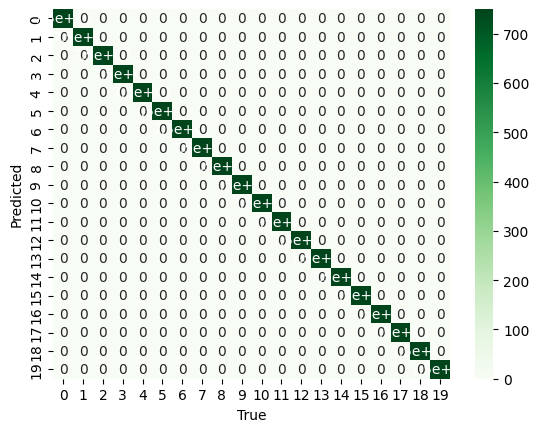

In [123]:
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### Parameter tuning - I map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"

In [37]:
# For metric choice with cross_val_score see: https://scikit-learn.org/0.15/modules/model_evaluation.html
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [125]:
scores = cross_val_score(dt, X_train, y_train, cv=5)
print(scores)

[0.43233333 0.429      0.43633333 0.433      0.42133333]


Another confirm of overfitting, when dataset is splitted into train and validation, the performances drastically drop, pointing out that the tree formed is just adapting to data, not classifying.

Before exploring a randomized search, we want to have an idea of what kind of values are reasonable for the most interesting parameters of the tree. 

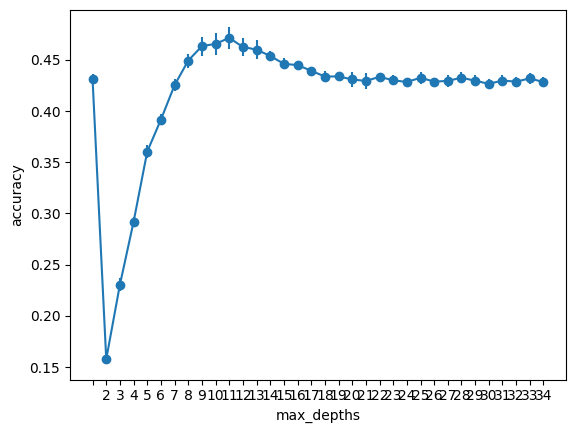

In [126]:
# considering max_depth
max_depths = [None] + list(np.arange(2, 35))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

Best `max_depth` alone seems 10, but let's see other parameters and then let's do the random search.

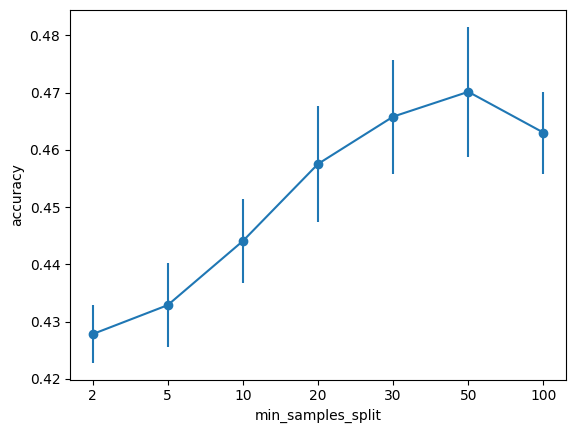

In [127]:
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

In [128]:
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

CPU times: user 6.98 s, sys: 1.89 s, total: 8.87 s
Wall time: 3min 27s


In [165]:
clf = random_search.best_estimator_

In [166]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 11, 'criterion': 'gini'} 0.4756066666666666


Let's see the shape parameters of the tuned tree.

In [167]:
clf.tree_.n_leaves


572

Okay, it is a big improvement! From >5000 to 707. 

In [168]:
clf.tree_.node_count

1143

In [169]:
clf.tree_.max_depth

11

The number of nodes is /10 (!!) and the max depth is less than the half. 

In [170]:
y_train_pred = clf.predict(X_train)

In [171]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       750
           1       0.74      0.77      0.75       750
           2       0.47      0.46      0.47       750
           3       0.71      0.66      0.68       750
           4       0.65      0.68      0.67       750
           5       0.56      0.50      0.53       750
           6       0.47      0.50      0.48       750
           7       0.80      0.86      0.83       750
           8       0.71      0.57      0.63       750
           9       0.44      0.40      0.42       750
          10       0.49      0.57      0.53       750
          11       0.66      0.52      0.58       750
          12       0.88      0.85      0.86       750
          13       0.43      0.44      0.44       750
          14       0.73      0.54      0.62       750
          15       0.43      0.51      0.46       750
          16       0.53      0.62      0.57       750
          17       0.49    

Those are reasonable, no longer overfitted by eye. Let's do the final tuning and then test and evaluate the final performances. 

In [172]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.22314352035114152
duration_min 0.13059161574153474
danceability 0.11763372428484879
acousticness 0.1158754622964092
loudness 0.08854602883866455
valence 0.07629476159987135
instrumentalness 0.07582525403445198
energy 0.05477365118030893
speechiness 0.05030835145956379
tempo 0.04559446388317977
liveness 0.014061678015852126
explicit 0.0035661149237103396
key 0.0028695468273304673
mode 0.0009158265631324914
time_signature 0.0


Look... `key` and `time_signature` are not used. This seems weird, it is like said that key does not characterize `genre` at all.

In [173]:
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)

In [174]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058131,0.013629,0.000897,0.000779,5,30,2,entropy,"{'min_samples_split': 5, 'min_samples_leaf': 3...",0.164333,...,0.167333,0.164000,0.166333,0.161333,0.164000,0.168333,0.164000,0.164400,0.002520,188
1,0.028828,0.005140,0.001114,0.000921,100,50,2,gini,"{'min_samples_split': 100, 'min_samples_leaf':...",0.155667,...,0.158333,0.151667,0.155000,0.162000,0.149333,0.163667,0.151000,0.155280,0.004930,195
2,0.284912,0.039754,0.001067,0.000513,20,10,10,entropy,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.456333,...,0.472000,0.472333,0.458667,0.465667,0.464000,0.467667,0.478667,0.464660,0.009252,25
3,0.081754,0.008372,0.001065,0.000554,30,50,6,gini,"{'min_samples_split': 30, 'min_samples_leaf': ...",0.375333,...,0.383333,0.391000,0.377333,0.393000,0.390667,0.389667,0.387333,0.387007,0.007746,161
4,0.161646,0.024306,0.001311,0.000880,10,1,12,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.464000,...,0.466667,0.470333,0.477000,0.464667,0.471000,0.474667,0.466667,0.469240,0.007699,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.237595,0.009670,0.000991,0.000354,2,30,16,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 3...",0.446667,...,0.477000,0.466667,0.459333,0.458000,0.462333,0.460333,0.475333,0.458487,0.010634,70
196,0.137013,0.006688,0.001144,0.000479,2,20,18,gini,"{'min_samples_split': 2, 'min_samples_leaf': 2...",0.461667,...,0.464000,0.472333,0.496000,0.481667,0.468667,0.471000,0.471000,0.472387,0.009417,11
197,0.088181,0.016539,0.000979,0.000468,2,50,3,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.249333,...,0.255000,0.262333,0.259667,0.262000,0.253667,0.248333,0.247333,0.254653,0.005340,180
198,0.141260,0.015969,0.001333,0.001110,50,20,None,gini,"{'min_samples_split': 50, 'min_samples_leaf': ...",0.461000,...,0.461000,0.474333,0.488667,0.474333,0.465000,0.473000,0.469000,0.470367,0.009390,19


#### Notes on attributes of `random_search.cv_results_`
`rank_test_score` indicates the rank of a grid search parameter combination based on the `mean_test_score`.

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

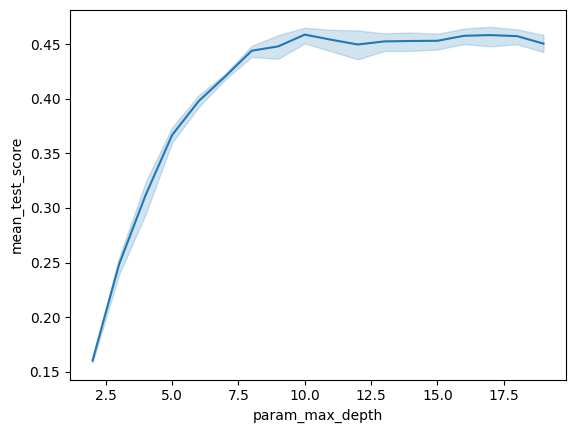

In [175]:
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

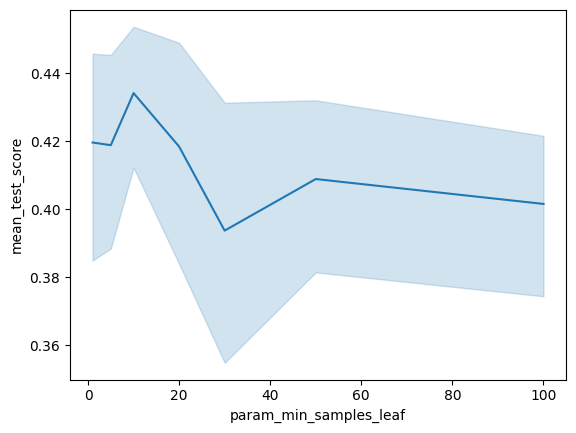

In [176]:
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

## Post-pruning and complexity evaluation

In [177]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

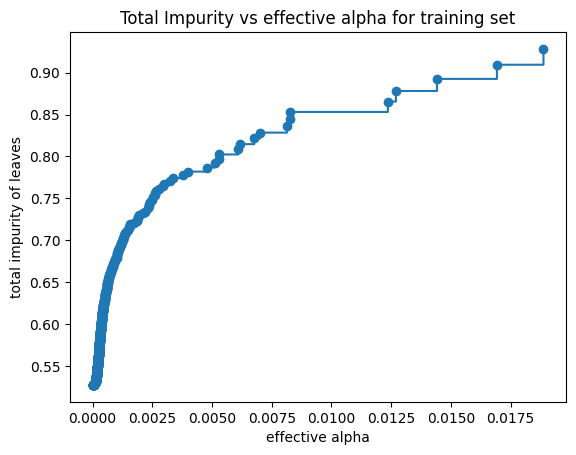

In [178]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [179]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    print( "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
)

Number of nodes in the last tree is: 1143 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1141 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1137 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1135 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1133 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1131 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1129 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1127 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1125 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1123 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1119 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1117 with ccp_alpha: 0.02152176805850825
Number of nodes in the last tree is: 1115 with ccp_alpha: 0.0215

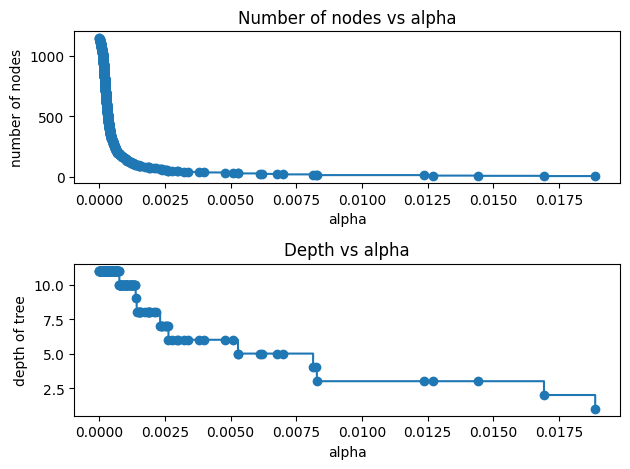

In [180]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Choosing `ccp_alpha` as the elbow point for those graphs (clearly, it is not a defined point, trade-offing by eye) so taking `ccp_alpha` = 0.0025 .

In [197]:
# Implementing the final-tuned tree
best_ccp_alpha = 0.0025
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha, **random_search.best_params_)

In [198]:
#Training the best-tuned tree
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0025, max_depth=11, min_samples_leaf=5,
                       min_samples_split=20, random_state=0)

#### Best tuned tree on training - performances and shape on training set

In [199]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       750
           1       0.74      0.77      0.75       750
           2       0.47      0.46      0.47       750
           3       0.71      0.66      0.68       750
           4       0.65      0.68      0.67       750
           5       0.56      0.50      0.53       750
           6       0.47      0.50      0.48       750
           7       0.80      0.86      0.83       750
           8       0.71      0.57      0.63       750
           9       0.44      0.40      0.42       750
          10       0.49      0.57      0.53       750
          11       0.66      0.52      0.58       750
          12       0.88      0.85      0.86       750
          13       0.43      0.44      0.44       750
          14       0.73      0.54      0.62       750
          15       0.43      0.51      0.46       750
          16       0.53      0.62      0.57       750
          17       0.49    

In [200]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.2810686824933053
danceability 0.17412841449934147
duration_min 0.13705822566882386
loudness 0.11196405892520342
instrumentalness 0.09368484274591707
acousticness 0.09018049809505584
speechiness 0.04111389861802162
valence 0.030697238178044636
energy 0.027220149463695748
tempo 0.012883991312591167
explicit 0.0
key 0.0
mode 0.0
liveness 0.0
time_signature 0.0


It is possible to see which are the real-used attributes for the tree classification, that are no longer all. 

In [201]:
print(f'Shapes of the tree: number of nodes = {clf.tree_.node_count}, number of leaf nodes = {clf.tree_.n_leaves}, maximum depth = {clf.tree_.max_depth}')

Shapes of the tree: number of nodes = 57, number of leaf nodes = 29, maximum depth = 7


## Evaluating final performances of the tree on test set for I `genre` map and finding the best `ccp_alpha`

Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_.

In [204]:
y_train_pred = clf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_train_pred))

Accuracy: 0.3926


In [205]:
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.369


In [206]:
clf.score(X_test, y_test)

0.369

In [207]:
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.3926
Train F1-score [0.50139276 0.56664006 0.         0.48879837 0.46461372 0.28521435
 0.         0.67001886 0.32952253 0.         0.34331984 0.4024864
 0.74793388 0.21844226 0.54914197 0.         0.38751346 0.38449491
 0.59254948 0.27315542]

Test Accuracy 0.369
Test F1-score [0.48625793 0.51941748 0.         0.5115304  0.45806452 0.24146982
 0.         0.66536965 0.29166667 0.         0.3280543  0.39719626
 0.70833333 0.18571429 0.46226415 0.         0.38184664 0.37440758
 0.5380531  0.22680412]


In [208]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.2810686824933053
danceability 0.17412841449934147
duration_min 0.13705822566882386
loudness 0.11196405892520342
instrumentalness 0.09368484274591707
acousticness 0.09018049809505584
speechiness 0.04111389861802162
valence 0.030697238178044636
energy 0.027220149463695748
tempo 0.012883991312591167
explicit 0.0
key 0.0
mode 0.0
liveness 0.0
time_signature 0.0


In [190]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.46      0.49       250
           1       0.66      0.43      0.52       250
           2       0.00      0.00      0.00       250
           3       0.54      0.49      0.51       250
           4       0.38      0.57      0.46       250
           5       0.35      0.18      0.24       250
           6       0.00      0.00      0.00       250
           7       0.65      0.68      0.67       250
           8       0.30      0.28      0.29       250
           9       0.00      0.00      0.00       250
          10       0.23      0.58      0.33       250
          11       0.48      0.34      0.40       250
          12       0.74      0.68      0.71       250
          13       0.14      0.26      0.19       250
          14       0.56      0.39      0.46       250
          15       0.00      0.00      0.00       250
          16       0.31      0.49      0.38       250
          17       0.27    

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


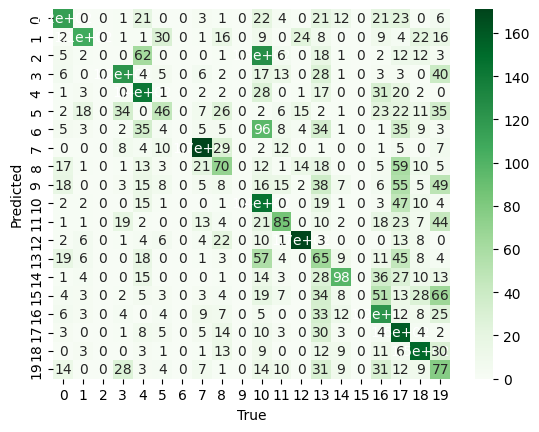

In [217]:
#Confusion matrix for test set
#plt.figure(figsize=(7,7))
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [192]:
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above

This first confusion matrix can help uderstanding the weak points. For example, genra `brazil` (number 2) and `industrial` (number 15), are never predicted, so always misclassified, some of them most of the times to another category, but sometimes distributed on more than one.  
`sleep` and `study` seems pretty well detected, this gives hope to find a good binary classificator. 

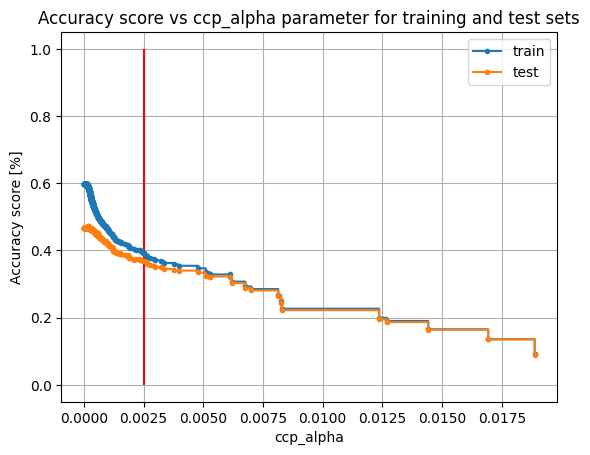

In [196]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy score [%]")
ax.grid()
ax.vlines(0.0025, 0,1, color='r')
ax.set_title("Accuracy score vs ccp_alpha parameter for training and test sets")
ax.plot(ccp_alphas, train_scores, marker=".", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker=".", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the first portion of the tree, where the pruning is not done or for just few branches, the overfitting is evident, because there is a big gap between performances of training and test set.  
We choose `ccp_alpha` that gives the best accuracy for the test set and a reasonably little gap between performances of the training test: `ccp_alpha`` = 0.0025$ as already chosen using the only train set, because of this, performances has been already evaluated.

In [156]:
print('Train Accuracy %s' % cross_val_score(dt, X_train, y_train))

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))

Train Accuracy [0.46233333 0.45033333 0.47333333 0.46466667 0.46433333]
Test Accuracy 0.369


In [161]:
clf.tree_.n_leaves

29

In [162]:
clf.tree_.max_depth

7

In [163]:
clf.tree_.node_count

57

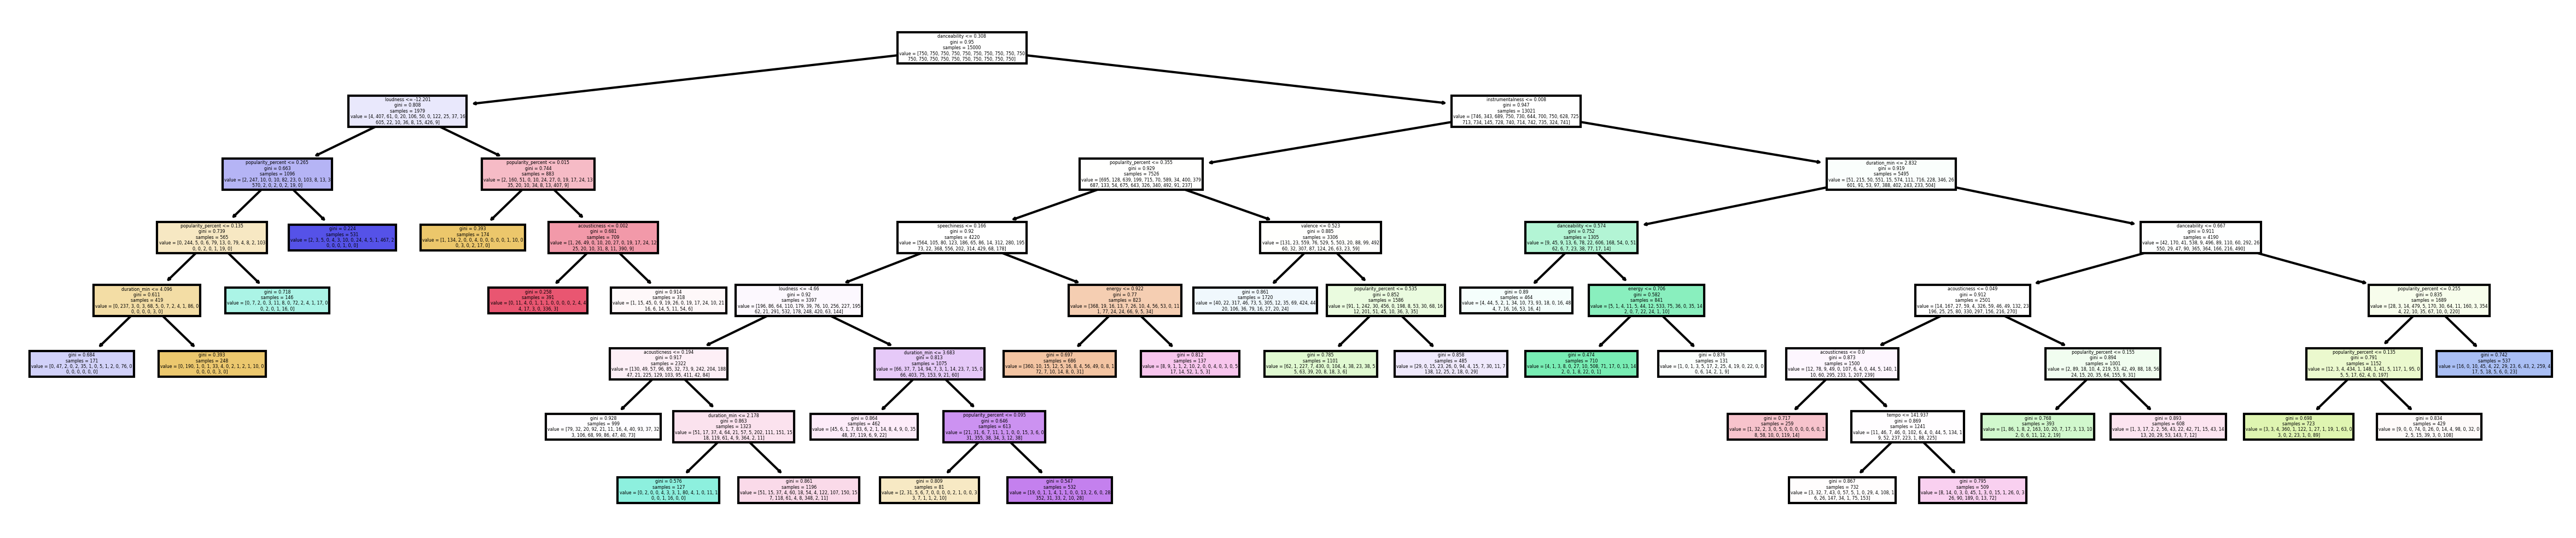

In [157]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=attributes, filled=True)
plt.show()

In [158]:
#just for reference: 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}

# Second map - macrogenre map

Just for reference, here there is the macrogenre map chosen using Wiki list and considering the confusion matrix of the first tree. 

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -------------------------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` , `industrial`|
| 1 | Pop + Asian| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`, `indian`|
| 2 | Latin | `forro`,`brazil`,`spanish`|
| 3 | Country | `bluegrass`|
| 4 | Metal | `black metal`|
| 5 | Iranian | `iranian`|
| 6 | Others | `sleep`, `study`|

#### Creating II dataset

In [18]:
df_train.replace({'genre':macrogenre_map}, inplace=True)
df_test.replace({'genre':macrogenre_map}, inplace=True)

In [19]:
y_train2 = df_train['genre']
y_test2 = df_test['genre']

In [22]:
X_train2 = df_train[attributes].values
X_test2 = df_test[attributes].values

In [23]:
print(y_train2)

0        1
1        5
2        4
3        3
4        1
        ..
14995    0
14996    6
14997    0
14998    0
14999    1
Name: genre, Length: 15000, dtype: int64


In [24]:
print(X_train2)

[[4.029333333333334 False 0.46 ... 0.635 142.221 4.0]
 [7.4 False 0.0 ... 0.0336 75.596 4.0]
 [5.558433333333333 False 0.03 ... 0.489 116.628 4.0]
 ...
 [6.668183333333333 False 0.43 ... 0.0708 126.0 4.0]
 [3.2875 False 0.37 ... 0.27 160.044 4.0]
 [3.3068166666666667 False 0.36 ... 0.784 88.003 4.0]]


# Decision tree - II map

In [27]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt2 = DecisionTreeClassifier()

In [28]:
%%time
dt2.fit(X_train2, y_train2)

CPU times: user 175 ms, sys: 3.36 ms, total: 178 ms
Wall time: 177 ms


DecisionTreeClassifier()

In [29]:
y_train_pred2 = dt2.predict(X_train2)

#### Characteristics of the II not-tuned tree

In [30]:
def tree_infos(dtree : DecisionTreeClassifier(), y_true : np.array, y_predicted : np.array, features : np.array) -> None:
    print(f'Size measures of the tree: n_leaves = {dtree.tree_.n_leaves}, max_depth = {dtree.tree_.max_depth}, node_count = {dtree.tree_.node_count}')
    print(f'{classification_report(y_true, y_predicted)}')
    zipped = zip(features, dtree.feature_importances_)
    zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    for col, imp in zipped:
        print(col, imp)

    return

In [31]:
tree_infos(dt2, y_train2, y_train_pred2, attributes)

Size measures of the tree: n_leaves = 3337, max_depth = 25, node_count = 6673
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4500
           1       1.00      1.00      1.00      4500
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00       750
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00      1500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

instrumentalness 0.13732094653799043
popularity_percent 0.12166630530575406
danceability 0.11800593571881911
duration_min 0.1108643748392463
acousticness 0.09616781708144083
tempo 0.06864126657593168
valence 0.06692296301808234
energy 0.06470741422229716
loudness 0.061011232950495035
speechiness 0.05999462511416981
liveness

The tree seems overfitted as before, there are 3333 leaves out of 15000 data points (mean cardinality 4.5).  
The tree is using all features for classification and has 'perfect' behaviour.  
Let's do cross validation for confirming overfitting theory:

In [32]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train2, y_train_pred2))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt2, X_train2, y_train2, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.59566667 0.59933333 0.59666667 0.59966667 0.599     ]


There we are, overfitting confirmed.

In [33]:
mean = np.mean([0.596,0.60133333, 0.59833333, 0.59266667, 0.607])
print(mean)

0.599066666


As we could expect, this is a lot better than first tree, because there are less then the half of the classes. 

### Parameter tuning - II map
#### Randomized Search

Before exploring a randomized search, we want to have an idea of what kind of values are reasonable for the most interesting parameters of the tree. 

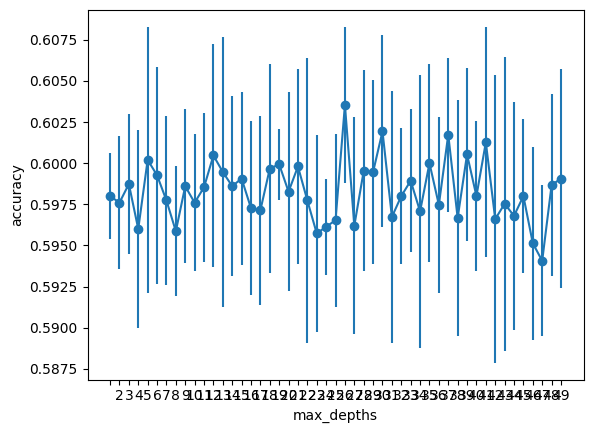

In [34]:
# considering max_depth
max_depths = [None] + list(np.arange(2, 50))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt2, X_train2, y_train2, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

This is interesting, seems like this does not really affect the result. 

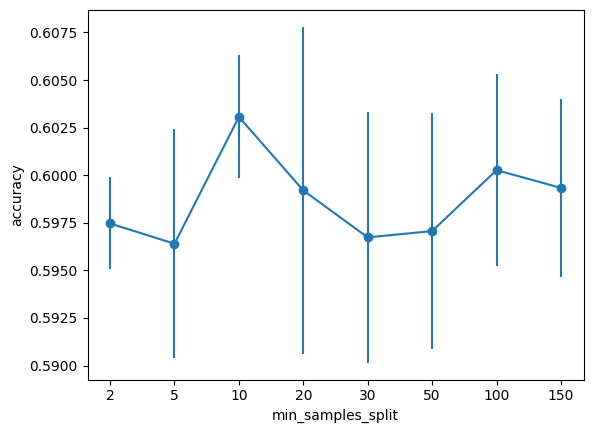

In [35]:
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100, 150])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt2, X_train2, y_train2, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

In [38]:
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 30)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100, 150],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train2, y_train2)
clf2 = random_search.best_estimator_

CPU times: user 54.7 s, sys: 8.31 s, total: 1min 2s
Wall time: 3min 3s


In [39]:
clf2 = random_search.best_estimator_

In [40]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'entropy'} 0.6370266666666667


As we could expect, the `min_samples_split` parameter grew higher. This makes sense bc in a macroclass there are more elements.

Let's see the shape parameters of the tuned tree.

In [41]:
y_train_pred2 = clf2.predict(X_train2)

In [42]:
tree_infos(clf2, y_train2, y_train_pred2, attributes)

Size measures of the tree: n_leaves = 356, max_depth = 10, node_count = 711
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      4500
           1       0.64      0.73      0.68      4500
           2       0.66      0.57      0.61      2250
           3       0.69      0.47      0.56       750
           4       0.85      0.68      0.75       750
           5       0.68      0.75      0.71       750
           6       0.84      0.78      0.81      1500

    accuracy                           0.70     15000
   macro avg       0.73      0.68      0.70     15000
weighted avg       0.70      0.70      0.70     15000

instrumentalness 0.23271110540184278
popularity_percent 0.17463542482495184
acousticness 0.17241553781721397
danceability 0.1464397065469258
duration_min 0.0713470402179349
loudness 0.04528639435729018
valence 0.04521231026873329
energy 0.03660273109069864
tempo 0.035728805949775094
speechiness 0.024999005364171448
liveness 0

The tree is still using all features for parameter estimation... weird.  
Anyway, the size has been reduced of a factor 10.

In [43]:
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)

In [44]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124423,0.032369,0.002965,0.001984,10,10,8,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.627333,...,0.615000,0.628000,0.626333,0.619667,0.638000,0.636333,0.634000,0.628120,0.008170,70
1,0.130179,0.025688,0.003227,0.002426,50,30,23,gini,"{'min_samples_split': 50, 'min_samples_leaf': ...",0.616000,...,0.626333,0.626667,0.618333,0.628000,0.638000,0.644000,0.629333,0.628580,0.009394,43
2,0.104309,0.019858,0.003051,0.002200,10,150,6,entropy,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.571000,...,0.587000,0.595667,0.569333,0.595333,0.592000,0.591000,0.585000,0.586933,0.008552,165
3,0.043049,0.010734,0.003022,0.003644,20,30,3,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.504667,...,0.517667,0.522667,0.516333,0.502667,0.523333,0.522000,0.526000,0.517180,0.006105,183
4,0.191848,0.018645,0.002601,0.001862,30,20,27,entropy,"{'min_samples_split': 30, 'min_samples_leaf': ...",0.630333,...,0.633333,0.631333,0.626667,0.614667,0.646000,0.639667,0.636000,0.635047,0.008420,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.148865,0.014757,0.002523,0.001854,150,50,12,entropy,"{'min_samples_split': 150, 'min_samples_leaf':...",0.613667,...,0.614667,0.640333,0.613667,0.621333,0.622000,0.623333,0.616000,0.620707,0.009186,91
196,0.154622,0.019263,0.002661,0.001921,100,10,8,entropy,"{'min_samples_split': 100, 'min_samples_leaf':...",0.614667,...,0.619333,0.634000,0.619667,0.626667,0.621333,0.633333,0.635333,0.628193,0.008034,68
197,0.159651,0.015878,0.002994,0.002283,2,50,16,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.621667,...,0.614333,0.638000,0.630667,0.625333,0.627333,0.629667,0.626667,0.628267,0.008780,58
198,0.161913,0.027312,0.003653,0.005905,30,50,23,entropy,"{'min_samples_split': 30, 'min_samples_leaf': ...",0.621667,...,0.614333,0.638000,0.630667,0.625333,0.627333,0.629667,0.626667,0.628267,0.008780,58


<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

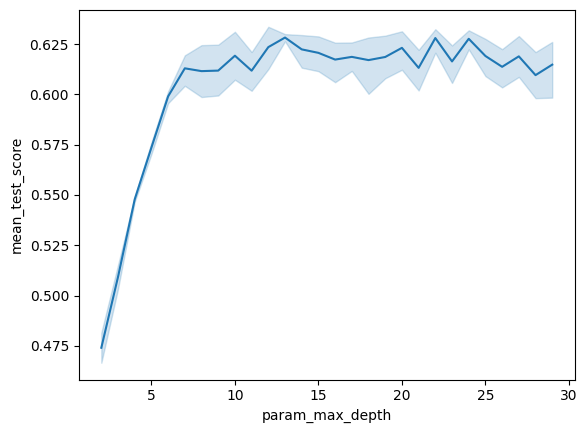

In [45]:
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

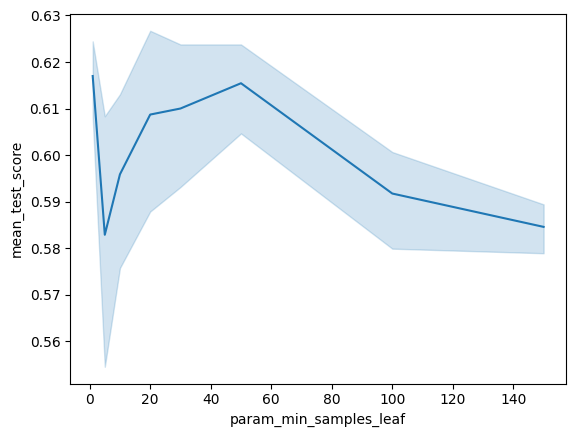

In [46]:
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

## Post-pruning and complexity evaluation of II tree

In [47]:
path = clf2.cost_complexity_pruning_path(X_train2, y_train2)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

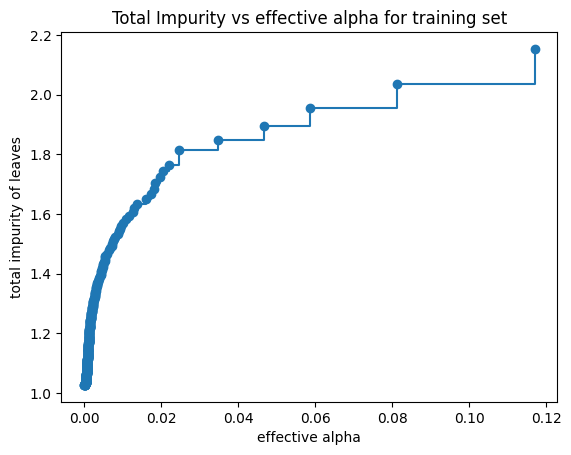

In [48]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [49]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf2 = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf2.fit(X_train2, y_train2)
    clfs.append(clf2)
    print( "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
)

Number of nodes in the last tree is: 711 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 709 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 707 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 705 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 703 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 701 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 697 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 697 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 695 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 693 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 691 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 689 with ccp_alpha: 0.27982774229502594
Number of nodes in the last tree is: 687 with ccp_alpha: 0.27982774229502594

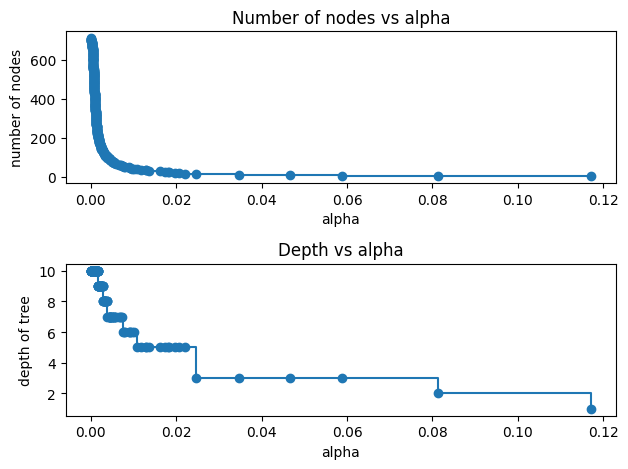

In [50]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Choosing `ccp_alpha` as the elbow point for those graphs (clearly, it is not a defined point, trade-offing by eye) so taking `ccp_alpha` = 0.01 .

In [51]:
# Implementing the final-tuned tree
best_ccp_alpha = 0.01
clf2 = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha, **random_search.best_params_)

In [52]:
#Training the best-tuned tree
clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=10,
                       min_samples_leaf=20, min_samples_split=20,
                       random_state=0)

In [53]:
y_train_pred2 = clf2.predict(X_train2)

#### Best tuned tree on training - performances and shape on training set

In [54]:
tree_infos(clf2, y_train2, y_train_pred2, attributes)

Size measures of the tree: n_leaves = 22, max_depth = 6, node_count = 43
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      4500
           1       0.49      0.67      0.57      4500
           2       0.60      0.41      0.48      2250
           3       0.00      0.00      0.00       750
           4       0.61      0.60      0.61       750
           5       0.59      0.54      0.56       750
           6       0.61      0.79      0.69      1500

    accuracy                           0.58     15000
   macro avg       0.51      0.51      0.51     15000
weighted avg       0.56      0.58      0.56     15000

instrumentalness 0.3419234473174398
acousticness 0.22411531919740654
danceability 0.15818235001251382
popularity_percent 0.1491457404669472
duration_min 0.0672327615090568
tempo 0.020883171094963186
energy 0.019977970469024647
loudness 0.018539239932648086
explicit 0.0
key 0.0
mode 0.0
speechiness 0.0
liveness 0.0
valence 0.0
ti

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, a lot of weights are set to 0.

## Evaluating final performances of the tree on test set for II `genre` map and finding the best `ccp_alpha`

Finally predicting on test set

In [55]:
y_test_pred2 = clf2.predict(X_test2)

Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_.

In [56]:
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train2, y_train_pred2))
print('Train F1-score %s' % f1_score(y_train2, y_train_pred2, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test2, y_test_pred2))
print('Test F1-score %s' % f1_score(y_test2, y_test_pred2, average=None))

Train Accuracy 0.5758
Train F1-score [0.62784392 0.56828028 0.48481648 0.         0.60634706 0.56467316
 0.68777229]

Test Accuracy 0.5724
Test F1-score [0.620014   0.57257372 0.49501916 0.         0.59459459 0.53815261
 0.67443946]


Seems like we pruned properly, the accuracies are almost the same. 

In [57]:
#Classification report for test set
print(classification_report(y_test2, y_test_pred2))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1500
           1       0.50      0.67      0.57      1500
           2       0.58      0.43      0.50       750
           3       0.00      0.00      0.00       250
           4       0.62      0.57      0.59       250
           5       0.54      0.54      0.54       250
           6       0.61      0.75      0.67       500

    accuracy                           0.57      5000
   macro avg       0.50      0.51      0.50      5000
weighted avg       0.55      0.57      0.56      5000



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy score [%]")
ax.grid()
ax.vlines(0.01, 0.4,0.8, color='r')
ax.set_title("Accuracy score vs ccp_alpha parameter for training and test sets")
ax.plot(ccp_alphas, train_scores, marker=".", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker=".", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

NameError: name 'X_train' is not defined

In [ ]:
infostree_infos(clf2, y_test2, y_test_pred2, attributes)

Size measures of the tree: n_leaves = 22, max_depth = 6, node_count = 43
The classification report is:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1500
           1       0.50      0.67      0.57      1500
           2       0.58      0.43      0.50       750
           3       0.00      0.00      0.00       250
           4       0.62      0.57      0.59       250
           5       0.54      0.54      0.54       250
           6       0.61      0.75      0.67       500

    accuracy                           0.57      5000
   macro avg       0.50      0.51      0.50      5000
weighted avg       0.55      0.57      0.56      5000

Feature importance : 
instrumentalness 0.3419234473174398
acousticness 0.22411531919740654
danceability 0.15818235001251382
popularity_percent 0.1491457404669472
duration_min 0.0672327615090568
tempo 0.020883171094963186
energy 0.019977970469024647
loudness 0.018539239932648086
explicit 0.0
key 0.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


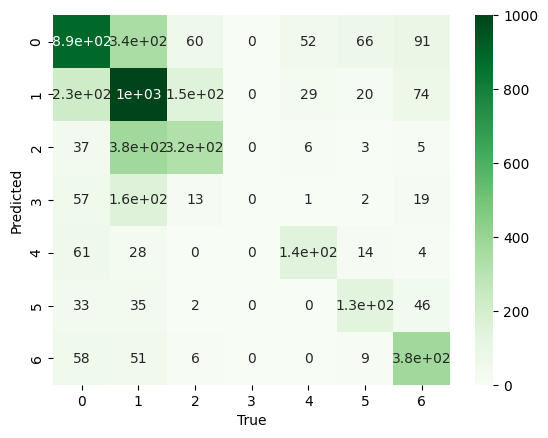

In [349]:
#Confusion matrix for test set
#plt.figure(figsize=(7,7))
cf = confusion_matrix(y_test2, y_test_pred2)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

`bluegrass` (the only country genre here) is now never predicted, before it had a pretty good accuracy, around 50%.  
This could be merged into Pop + Asian bc in frist tree genra of that group were confused the most with `bluegrass` wrt other macrogroups.  
Being the tree tuned as best as we could, it has to be assured that, for classification by genra, those attributes are not enough for obtaining a reasonable result. 

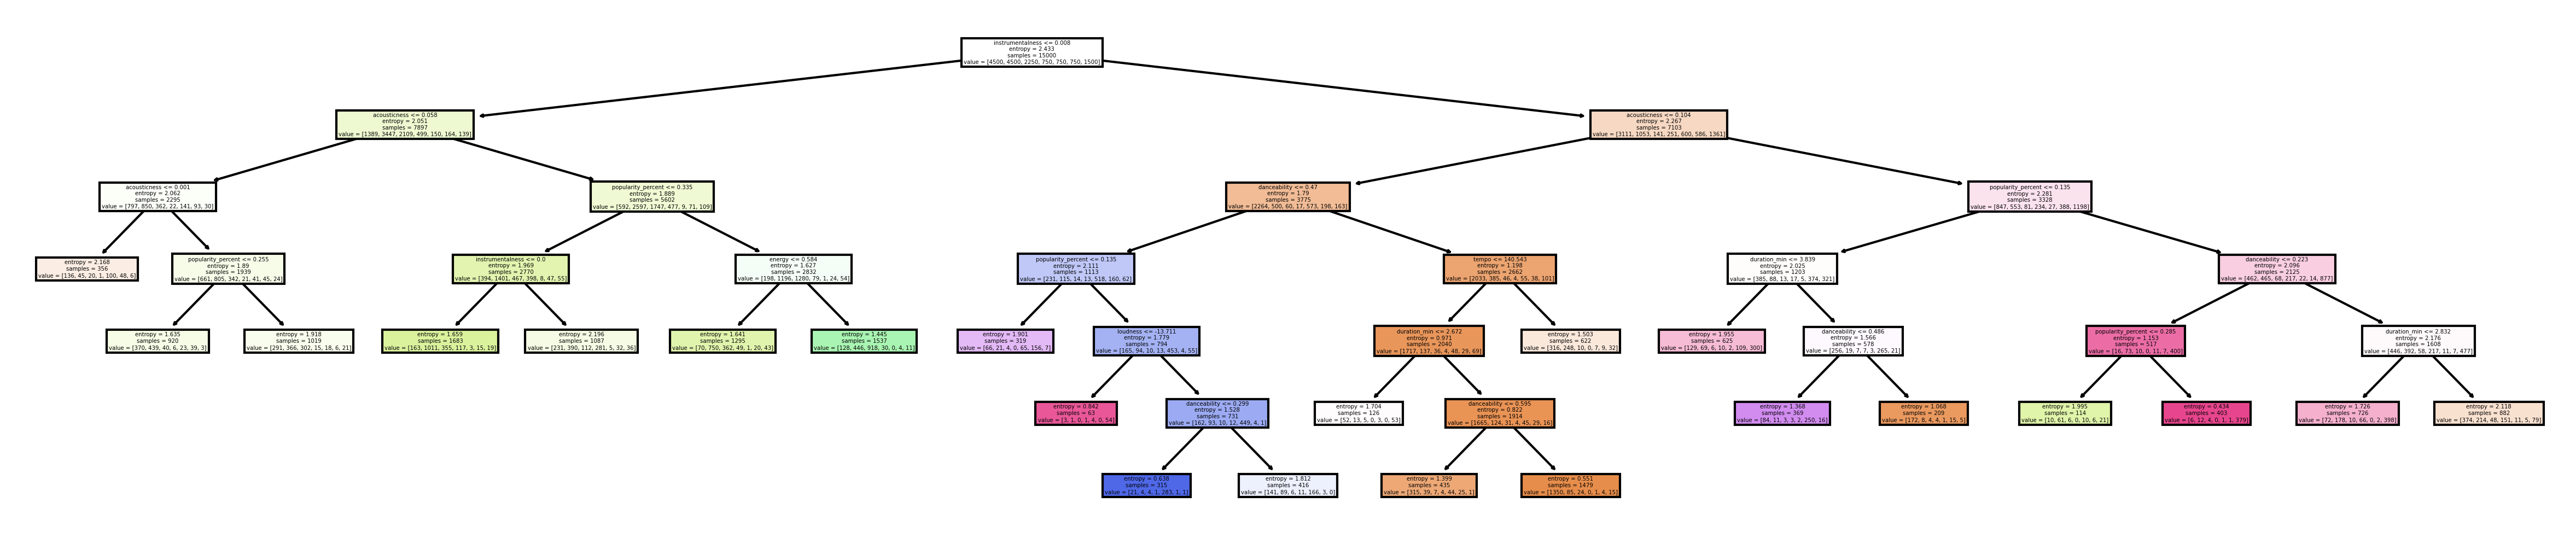

In [345]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf2, feature_names=attributes, filled=True)
plt.show()

#### Creating III dataset - binary splitting

Ok, I think we are going to do the following:
- classification `sleep` vs all other genra;
- classification of data objects characterized as 'music' vs 'non-music' with the criteria expressed above: (`time_signature` <= or `tempo` < 20).

In [145]:
df_train["is_music"] = (df_train['genre'] != 'sleep').astype(int) # add column
df_test["is_music"] = (df_test['genre'] != 'sleep').astype(int) # add column

In [146]:
df_train.head()

,duration_min,explicit,popularity_percent,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,is_music
0,4.029333,False,0.46,0.690,0.513,5,-12.529,1.0,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,j-dance,1
1,7.400000,False,0.00,0.069,0.196,1,-24.801,0.0,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,iranian,1
2,5.558433,False,0.03,0.363,0.854,2,-7.445,1.0,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,black-metal,1
3,4.496667,False,0.23,0.523,0.585,5,-5.607,1.0,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,bluegrass,1
4,5.127517,False,0.25,0.643,0.687,7,-11.340,1.0,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,happy,1


In [147]:
y_train = df_train['is_music']
y_test = df_test['is_music']

X_train = np.array(df_train[attributes])
X_test = np.array(df_test[attributes])

In [151]:
X_train

array([[4.029333333333334, False, 0.46, ..., 0.635, 142.221, 4.0],
       [7.4, False, 0.0, ..., 0.0336, 75.596, 4.0],
       [5.558433333333333, False, 0.03, ..., 0.489, 116.628, 4.0],
       ...,
       [6.668183333333333, False, 0.43, ..., 0.0708, 126.0, 4.0],
       [3.2875, False, 0.37, ..., 0.27, 160.044, 4.0],
       [3.3068166666666667, False, 0.36, ..., 0.784, 88.003, 4.0]],
      dtype=object)

# Decision tree - III map

For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 

In [148]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()

In [149]:
%%time
dt.fit(X_train, y_train)

CPU times: user 175 ms, sys: 2.02 ms, total: 177 ms
Wall time: 176 ms


DecisionTreeClassifier()

In [150]:
dt.tree_.max_depth

24

In [152]:
dt.tree_.n_leaves

244

Better than first case but really high... smells like overfitting. 

In [153]:
y_train_pred = dt.predict(X_train)

In [154]:
y_train


0        1
1        1
2        1
3        1
4        1
        ..
14995    1
14996    0
14997    1
14998    1
14999    1
Name: is_music, Length: 15000, dtype: int64

In [155]:
y_train_pred

array([1, 1, 1, ..., 1, 1, 1])

In [156]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1.]


In [157]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00     14250

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



There we are! Another overfitting. 

In [158]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.975      0.97533333 0.97466667 0.97533333 0.97366667]


Okay, it is overfitting again but cross validation gives promising results. 

In [159]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

valence 0.4188086243689985
loudness 0.22030806073145076
popularity_percent 0.12401853635771759
danceability 0.04765940488532201
acousticness 0.04061423568388328
duration_min 0.03253296158056629
instrumentalness 0.032436121675818184
energy 0.028988089499520347
liveness 0.01975871791363298
speechiness 0.012635034899285056
tempo 0.011862379485649837
key 0.006599303209669398
explicit 0.0020241437435734315
time_signature 0.0017543859649122805
mode 0.0


Didn't expect this, `valence` has an importance of 41% ! `time_signature` is not relevant as I would expect...

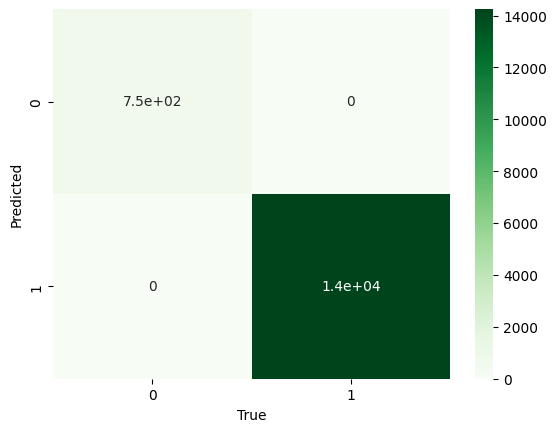

In [160]:
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### Parameter tuning - III map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"

In [161]:
# considering max_depth
max_depths = [None] + list(np.arange(2, 30))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

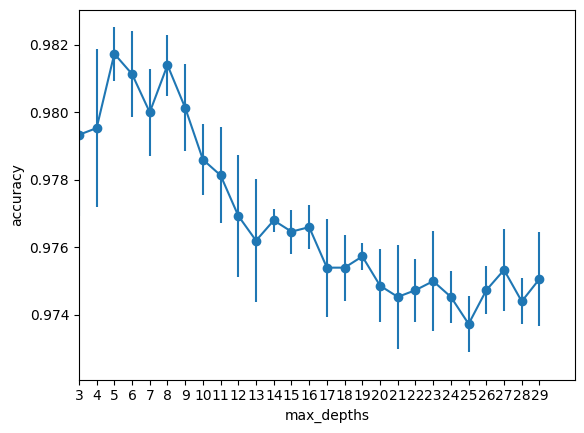

In [162]:
plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")

plt.xlim(2,30)
plt.show()

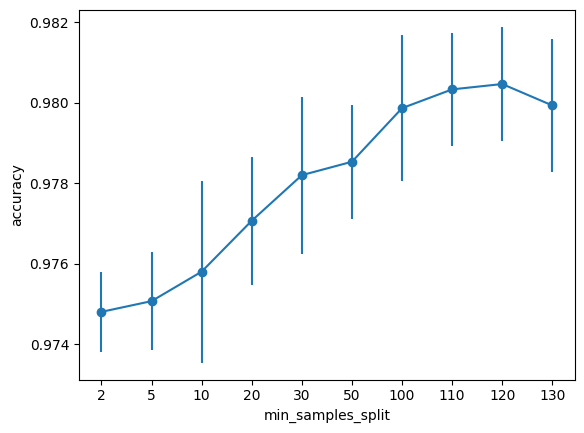

In [163]:
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100, 110, 120, 130])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

In [164]:
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100, 150],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

CPU times: user 33.2 s, sys: 4.72 s, total: 37.9 s
Wall time: 2min 21s


In [165]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 20, 'min_samples_leaf': 50, 'max_depth': 19, 'criterion': 'gini'} 0.9815666666666667


In [166]:
clf.tree_.n_leaves

54

In [167]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

valence 0.5277893762199051
loudness 0.28287211738390133
popularity_percent 0.1294456291338366
danceability 0.028046422253540138
duration_min 0.015764685149246442
acousticness 0.010060814744904622
speechiness 0.002299240591382307
instrumentalness 0.00142704119021195
energy 0.0013113492732756324
liveness 0.0006739566407185639
explicit 0.0003093674190773219
key 0.0
mode 0.0
tempo 0.0
time_signature 0.0


There we are... valence is tremendously important. 

In [168]:
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)

In [169]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.089936,0.017386,0.003022,0.003993,2,50,18,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.981667,...,0.979667,0.982667,0.982667,0.974000,0.982000,0.979667,0.983000,0.980200,0.003009,93
1,0.083698,0.008414,0.002417,0.001569,150,10,17,entropy,"{'min_samples_split': 150, 'min_samples_leaf':...",0.980000,...,0.980333,0.979333,0.982667,0.978333,0.977333,0.982333,0.981667,0.980307,0.002097,82
2,0.115138,0.014060,0.002900,0.002223,20,50,19,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.984333,...,0.982333,0.981333,0.983667,0.977667,0.982000,0.982667,0.982667,0.981567,0.002119,1
3,0.135356,0.014502,0.003012,0.002135,50,20,13,gini,"{'min_samples_split': 50, 'min_samples_leaf': ...",0.980333,...,0.981000,0.982667,0.983333,0.977000,0.981667,0.980000,0.983000,0.980713,0.002234,64
4,0.099887,0.015286,0.003188,0.002814,20,100,11,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.977667,...,0.976000,0.976333,0.979333,0.977667,0.981000,0.982667,0.976333,0.979713,0.002448,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.221048,0.054650,0.003824,0.004959,100,1,19,gini,"{'min_samples_split': 100, 'min_samples_leaf':...",0.981333,...,0.980667,0.981000,0.983333,0.975000,0.979667,0.981333,0.981667,0.979947,0.002120,113
196,0.039190,0.014683,0.004166,0.006448,100,5,2,gini,"{'min_samples_split': 100, 'min_samples_leaf':...",0.977667,...,0.976000,0.976333,0.979333,0.972000,0.979000,0.973333,0.976667,0.975620,0.002219,179
197,0.045787,0.006172,0.003040,0.002056,150,50,3,gini,"{'min_samples_split': 150, 'min_samples_leaf':...",0.981667,...,0.979000,0.980333,0.980667,0.977667,0.981000,0.982333,0.979667,0.980413,0.001960,79
198,0.082857,0.008910,0.003277,0.002111,2,50,5,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.983000,...,0.980333,0.982333,0.982667,0.974000,0.980667,0.981333,0.982667,0.980273,0.002924,85


<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

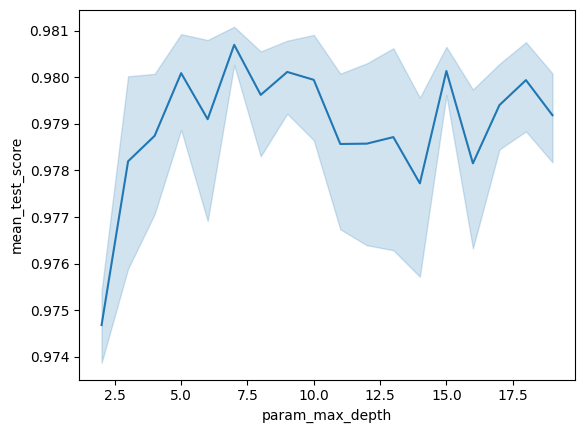

In [170]:
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

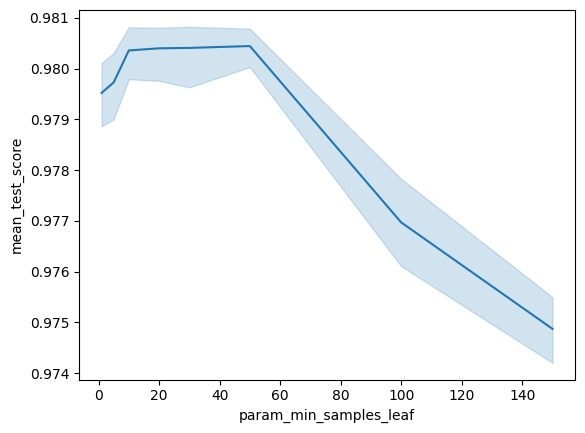

In [171]:
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

## Post-pruning and complexity evaluation - III map

In [172]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

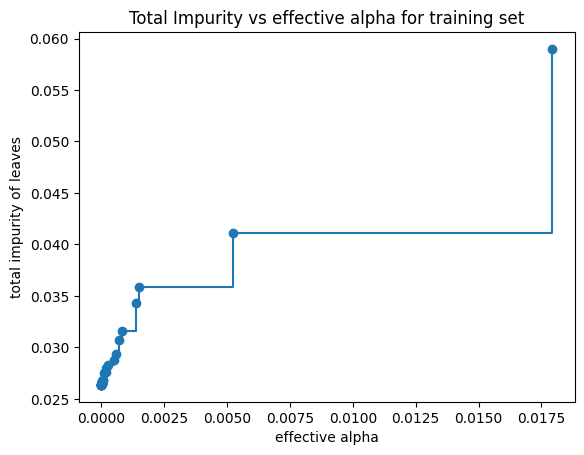

In [173]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [174]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03600732174857094


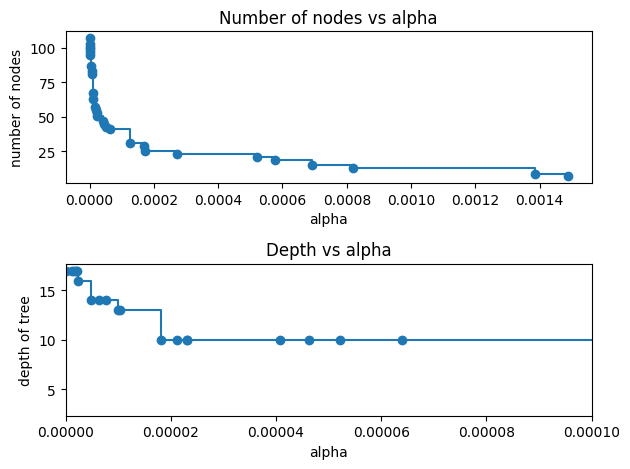

In [177]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_xlim(0,0.0001)
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

For now, a good choice of `ccp_alpha` seems `ccp_alpha` = 0.00001

In [178]:
best_ccp_alpha = 0.00001
clf = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, **random_search.best_params_)

In [179]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=1e-05, max_depth=19, min_samples_leaf=50,
                       min_samples_split=20)

In [180]:
y_train_pred = clf.predict(X_train)

Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_. After comparing accuracy of test and train, we will confirm or change the value of `ccp_alpha` and compute the final performances. 

In [181]:
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.9786


In [182]:
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.9825333333333334
Train F1-score [0.81678322 0.99082954]

Test Accuracy 0.9786
Test F1-score [0.76789588 0.98878289]


In [183]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       250
           1       0.98      0.99      0.99      4750

    accuracy                           0.98      5000
   macro avg       0.91      0.85      0.88      5000
weighted avg       0.98      0.98      0.98      5000



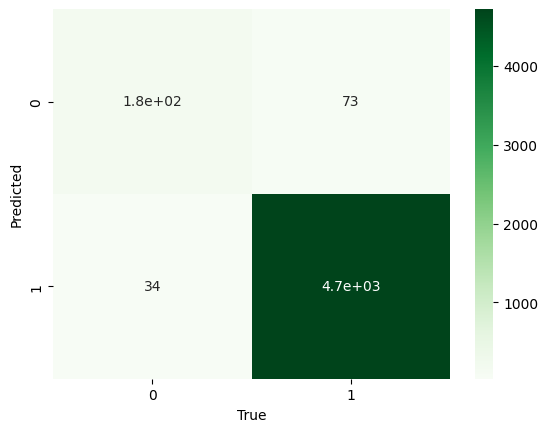

In [184]:
#Confusion matrix for test set
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [1]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.grid()
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

NameError: name 'clfs' is not defined

We decide to confirm the value of `ccp_alpha` already chosen, that is: `ccp_alpha` = 0.01 .
Note that this numbers come with no uncertainty, so it is not really relevant that test lies slightly over train accuracy. 

What to do now before doing the third map: 
- comments on first map []
- comments on second map []
- in particular, let's see if confusion matrix gives some hints about the choice of the second map []
- searching for some interesting metric of performance in literature []
- start to write report on both maps []

In [ ]:
# Decision tree - II map
from sklearn.tree import DecisionTreeClassifier, plot_tree

#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#class_weight=None, ccp_alpha=0.0)[source]
For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()
%%time
dt.fit(X_train, y_train)
dt.tree_.max_depth
dt.tree_.n_leaves
Better than first case but really high... smells like overfitting. 
y_train_pred = dt.predict(X_train)
y_train

y_train_pred
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print(classification_report(y_train, y_train_pred))
There we are! Another overfitting. 
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))
#### What is happening (again):
It is evident the _overfitting_. The tree is computed considering the whole train test, being the tree overfitted, it gives perfect behaviour. When only a part of the training is used and the rest has to be predicted, the performances drastically worsen, because the model is adapted only to the training specific instances. 
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)
As before, the tree is overfitting and so using all the attributes in order to adapt to data. 
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
### Parameter tuning - II map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"
# considering max_depth
max_depths = [None] + list(np.arange(2, 30))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")

plt.xlim(2,30)
plt.show()
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100, 110, 120, 130])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100, 150],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_
print(random_search.best_params_, random_search.best_score_)
clf.tree_.n_leaves
Results are pretty different than the ones in the first map, Accuracy is almost doubled. 
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)
There we are, seems better than before. 
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)
results
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")
## Post-pruning and complexity evaluation - II map
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[0].set_xlim(0,0.002)
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
For now, a good choice of `ccp_alpha` seems `ccp_alpha` = 0.01
best_ccp_alpha = 0.001
clf = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, **random_search.best_params_)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_. After comparing accuracy of test and train, we will confirm or change the value of `ccp_alpha` and compute the final performances. 
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))
print(classification_report(y_test, y_test_pred))
#Confusion matrix for test set
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.grid()
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.set_xlim(0,0.01)
ax.legend()
plt.show()
We decide to confirm the value of `ccp_alpha` already chosen, that is: `ccp_alpha` = 0.01 .
Note that this numbers come with no uncertainty, so it is not really relevant that test lies slightly over train accuracy. 